In [13]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from nltk.stem.porter import PorterStemmer

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('essays.csv',encoding='cp1252')
data.drop(['#AUTHID'], axis=1, inplace = True)
# label_map = {'n':0, 'y':1}
# data['cEXT'] = data['cEXT'].map(label_map)
# data['cNEU'] = data['cNEU'].map(label_map)
# data['cAGR'] = data['cAGR'].map(label_map)
# data['cCON'] = data['cCON'].map(label_map)
# data['cOPN'] = data['cOPN'].map(label_map)
data.head(10)

TEXT cEXT cNEU cAGR cCON cOPN
0  Well, right now I just woke up from a mid-day ...    n    y    y    n    y
1  Well, here we go with the stream of consciousn...    n    n    y    n    n
2  An open keyboard and buttons to push. The thin...    n    y    n    y    y
3  I can't believe it!  It's really happening!  M...    y    n    y    y    n
4  Well, here I go with the good old stream of co...    y    n    y    n    y
5  Today. Had to turn the music down. Today I wen...    y    n    y    n    y
6  Stream of consciousness. What should I write a...    n    n    y    n    n
7  The RTF305 Usenet site is a piece of garbage! ...    n    n    n    y    y
8  I'm really unsure about this assignment becaus...    y    y    n    y    y
9  Today was a tough day for me. I can't believed...    y    y    y    y    n

In [25]:
data.describe().T

count unique                                                top  freq
TEXT  2467   2467  today all I think about is snow skiing, I cann...     1
cEXT  2467      2                                                  y  1276
cNEU  2467      2                                                  n  1234
cAGR  2467      2                                                  y  1310
cCON  2467      2                                                  y  1253
cOPN  2467      2                                                  y  1271

In [26]:
data.shape

(2467, 6)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    2467 non-null   object
 1   cEXT    2467 non-null   object
 2   cNEU    2467 non-null   object
 3   cAGR    2467 non-null   object
 4   cCON    2467 non-null   object
 5   cOPN    2467 non-null   object
dtypes: object(6)
memory usage: 115.8+ KB


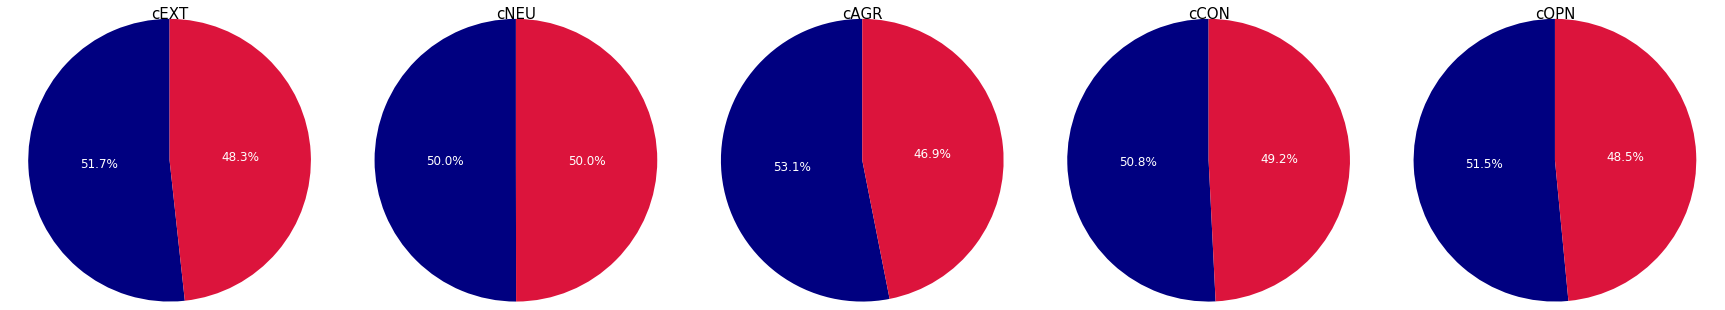

In [40]:
fig, ax = plt.subplots(1, 5, figsize=(30,5))
categorical_column = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
genre_col = ['navy','crimson']

for i in range(5):
    count = data[categorical_column[i]].value_counts()
    ax[i].pie(x = count.values, labels = ['y','n'], autopct='%1.1f%%', startangle=90, textprops={'size': 12, 'color': 'white'},
           pctdistance=0.5, radius=1.3, colors=genre_col)
    ax[i].set_title(categorical_column[i],fontdict={'fontsize': 15})

plt.show()

In [35]:
data.columns

Index(['TEXT', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], dtype='object')

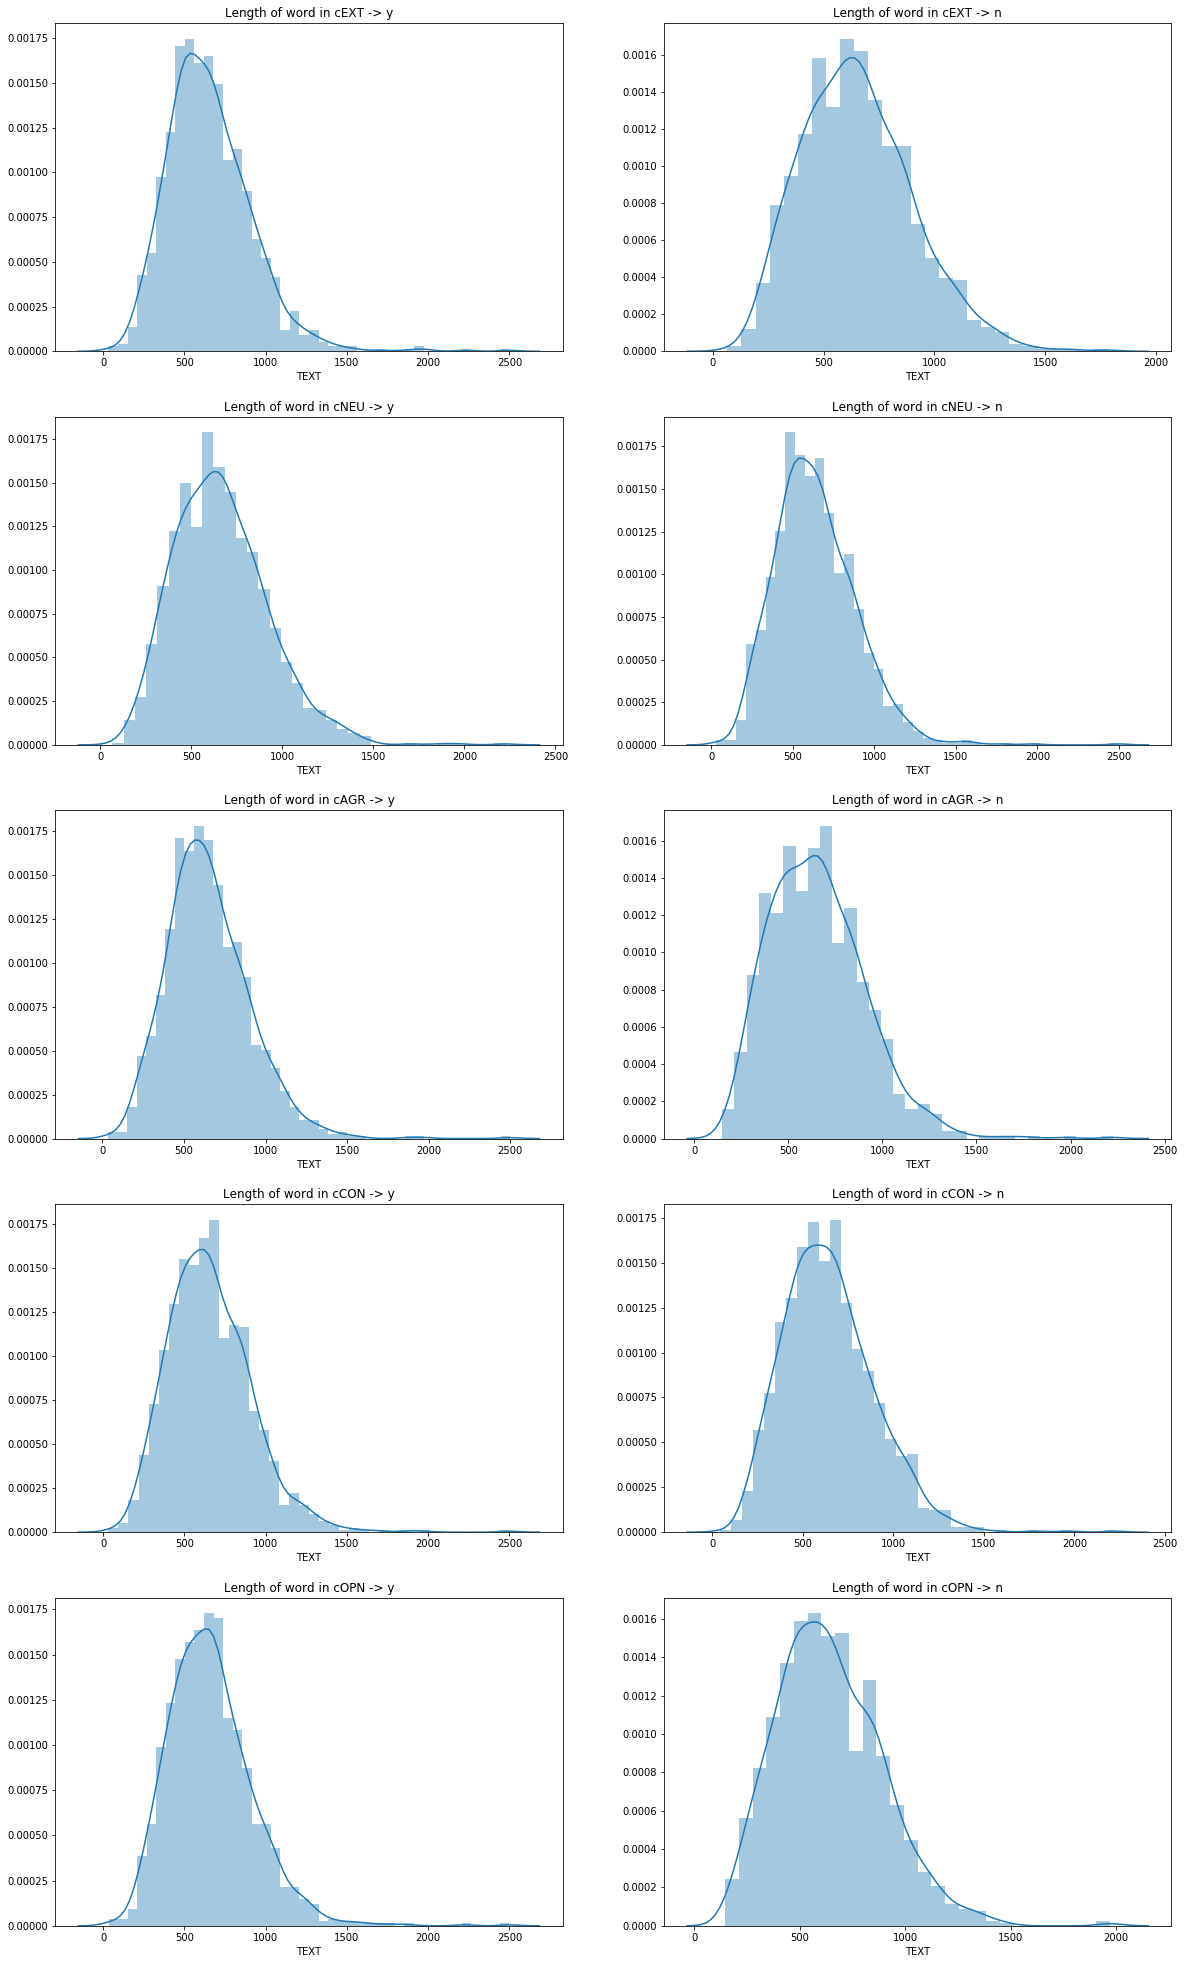

In [51]:
fig, ax = plt.subplots(5, 2, figsize=(20,35))
categorical_column = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
label_list = ['y','n']
mean_length_word = {}

for i in range(5):
    for j in range(2):
        dx = data[data[categorical_column[i]] == label_list[j]]
        words = dx['TEXT'].str.split().map(lambda x:len(x))
        mean_length_word[categorical_column[i]] = np.around(np.mean(words),decimals = 2)
        sns.distplot(words, ax = ax[i,j]).set(title = 'Length of word in ' + categorical_column[i]+" -> "+label_list[j])

plt.show()

In [53]:
data['TEXT'][100]

"Here I am sitting in the computer lab trying to track my thoughts. I am thinking that I shouldn't worry about what to think. I am not exactly sure why this assignment is necessary, but then again I am no psychologist. Whoa, change in thought. Now I am thinking of England and of how I wish I could go there to see the sights and see a close friend who lives there. Now I am sad because this reminds me of Princess Diana and of what a wonderful woman she was. I was truly saddened when I heard she died. She was on of those people that you dream of meeting some day even if you are only around her for  a moment. She was the type of person that could make your whole year just by smiling at you. This sadness takes me to other places, I am now simultaneously thinking of a close friend of mine who is clinically depressed and of old friend of the family who was homosexual and died this year of AIDS. I am a Christian and I have strong Christian beliefs but when tragedy strikes those you love the mo

In [11]:
def convert(post):
    posts = re.sub("[^a-zA-Z]", " ", post)
    post = re.sub('\s+', ' ', post)
    post = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", post)
    post = re.sub(r"\'s", " \'s ", post)
    post = re.sub(r"\'ve", " have ", post)
    post = re.sub(r"n\'t", " not ", post)
    post = re.sub(r"\'re", " are ", post)
    post = re.sub(r"\'d" , " would ", post)
    post = re.sub(r"\'ll", " will ", post)
    post = re.sub(r",", " , ", post)
#     post = re.sub(r",", " , ", post)
    post = re.sub(r"!", " ! ", post)
    post = re.sub(r"\(", " ( ", post)
    post = re.sub(r"\)", " ) ", post)
    post = re.sub(r"\?", " ", post)
    post = re.sub(r'[^\w\s]','',post)
    post = re.sub(' +', ' ', post).lower()
    

    post = post.strip()

    post = post.lower()
    post = post.split()
    post = [word for word in post if not word in set(stopwords.words('english'))]
#     ps = PorterStemmer()
#     post = [ps.stem(word) for word in post]
    post = ' '.join(post)

    return post

In [12]:
convert(data['TEXT'][100])

'sitting computer lab trying track thoughts thinking worry think exactly sure assignment necessary psychologist whoa change thought thinking england wish could go see sights see close friend lives sad reminds princess diana wonderful woman truly saddened heard died people dream meeting day even around moment type person could make whole year smiling sadness takes places simultaneously thinking close friend mine clinically depressed old friend family homosexual died year aids christian strong christian beliefs tragedy strikes love wonder doubt involving supposed loving god sometimes praise god things times ask always dreamer setting goals high sometimes wonder want life right god wanted go become minister life never simple try roll punches minister mine said people build barriers around order get hurt try experience least amount pain possible blocking said people cannot experience love much time protecting pain limiting lesser degree love possible want one people experience love greatly

In [13]:
corpus = data["TEXT"].apply(convert)

In [14]:
corpus

0       well right woke mid day nap sort weird ever si...
1       well go stream consciousness essay used things...
2       open keyboard buttons push thing finally worke...
3       ca believe really happening pulse racing like ...
4       well go good old stream consciousness assignme...
                              ...                        
2462    im home wanted go bed remembered psychology ho...
2463    stream consiousnesssskdj spell fuck know seem ...
2464    wednesday december 8th lot going semester tryi...
2465    man week hellish anyways time 20 minute writin...
2466    gotten phone brady im trying decide exacly wee...
Name: TEXT, Length: 2467, dtype: object

In [15]:
df_new = corpus.to_frame()

In [17]:
categorical_column = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
for i in categorical_column:
    df_new[i] = data[i]

df_new

TEXT cEXT cNEU cAGR cCON  \
0     well right woke mid day nap sort weird ever si...    n    y    y    n   
1     well go stream consciousness essay used things...    n    n    y    n   
2     open keyboard buttons push thing finally worke...    n    y    n    y   
3     ca believe really happening pulse racing like ...    y    n    y    y   
4     well go good old stream consciousness assignme...    y    n    y    n   
...                                                 ...  ...  ...  ...  ...   
2462  im home wanted go bed remembered psychology ho...    n    y    n    y   
2463  stream consiousnesssskdj spell fuck know seem ...    y    y    n    n   
2464  wednesday december 8th lot going semester tryi...    n    n    y    n   
2465  man week hellish anyways time 20 minute writin...    n    y    n    n   
2466  gotten phone brady im trying decide exacly wee...    n    y    y    n   

     cOPN  
0       y  
1       n  
2       y  
3       n  
4       y  
...   ...  
2462    n  
2463    y  
2464    n  
2465    y  
2466    y  

[2467 rows x 6 columns]

In [18]:
df_new.to_csv('cleaned.csv', index = False) 

In [3]:
df = pd.read_csv(r'cleaned.csv')
df

TEXT cEXT cNEU cAGR cCON  \
0     well right woke mid day nap sort weird ever si...    n    y    y    n   
1     well go stream consciousness essay used things...    n    n    y    n   
2     open keyboard buttons push thing finally worke...    n    y    n    y   
3     ca believe really happening pulse racing like ...    y    n    y    y   
4     well go good old stream consciousness assignme...    y    n    y    n   
...                                                 ...  ...  ...  ...  ...   
2462  im home wanted go bed remembered psychology ho...    n    y    n    y   
2463  stream consiousnesssskdj spell fuck know seem ...    y    y    n    n   
2464  wednesday december 8th lot going semester tryi...    n    n    y    n   
2465  man week hellish anyways time 20 minute writin...    n    y    n    n   
2466  gotten phone brady im trying decide exacly wee...    n    y    y    n   

     cOPN  
0       y  
1       n  
2       y  
3       n  
4       y  
...   ...  
2462    n  
2463    y  
2464    n  
2465    y  
2466    y  

[2467 rows x 6 columns]

In [20]:
# text_clf = Pipeline([('countvet', CountVectorizer()),('vect', TfidfVectorizer()), 
#                       ('clf', MultinomialNB()) ])

In [16]:
# convet = CountVectorizer(max_features=10000)
convet = CountVectorizer()
tfidf = TfidfTransformer()

vect = convet.fit_transform(df['TEXT'])
vect = tfidf.fit_transform(vect)

In [17]:
vect.shape

(2467, 29874)

In [6]:
label_map = {'n':0, 'y':1}
df['cEXT'] = df['cEXT'].map(label_map)
df['cNEU'] = df['cNEU'].map(label_map)
df['cAGR'] = df['cAGR'].map(label_map)
df['cCON'] = df['cCON'].map(label_map)
df['cOPN'] = df['cOPN'].map(label_map)

In [35]:
df

TEXT  cEXT  cNEU  cAGR  \
0     well right woke mid day nap sort weird ever si...     0     1     1   
1     well go stream consciousness essay used things...     0     0     1   
2     open keyboard buttons push thing finally worke...     0     1     0   
3     ca believe really happening pulse racing like ...     1     0     1   
4     well go good old stream consciousness assignme...     1     0     1   
...                                                 ...   ...   ...   ...   
2462  im home wanted go bed remembered psychology ho...     0     1     0   
2463  stream consiousnesssskdj spell fuck know seem ...     1     1     0   
2464  wednesday december 8th lot going semester tryi...     0     0     1   
2465  man week hellish anyways time 20 minute writin...     0     1     0   
2466  gotten phone brady im trying decide exacly wee...     0     1     1   

      cCON  cOPN  
0        0     1  
1        0     0  
2        1     1  
3        1     0  
4        0     1  
...    ...   ...  
2462     1     0  
2463     0     1  
2464     0     0  
2465     0     1  
2466     0     1  

[2467 rows x 6 columns]

In [18]:
from sklearn.model_selection import train_test_split
features_train, features_test, ext_train, ext_test, neu_train, neu_test, agr_train, agr_test, con_train, con_test, opn_train, opn_test = train_test_split(vect, df['cEXT'],df['cNEU'],df['cAGR'],df['cCON'], df['cOPN'], test_size = 0.20, random_state = 0)

In [19]:
features_train.shape, ext_train.shape, features_test.shape, ext_test.shape

((1973, 29874), (1973,), (494, 29874), (494,))

In [20]:
from xgboost import XGBClassifier

# fit model on training data
EXT = XGBClassifier()
EXT.fit(features_train, ext_train)
pickle.dump(EXT, open("extmodel.sav", "wb"))
EXT = pickle.load(open("extmodel.sav", "rb"))
ext_score_train=EXT.score(features_train,ext_train)
ext_score_test=EXT.score(features_test, ext_test)

NEU = XGBClassifier()
NEU.fit(features_train, neu_train)
pickle.dump(NEU, open("neumodel.sav", "wb"))
NEU = pickle.load(open("neumodel.sav", "rb"))
neu_score_train=NEU.score(features_train,neu_train)
neu_score_test=NEU.score(features_test,neu_test)


AGR = XGBClassifier()
AGR.fit(features_train, agr_train)
pickle.dump(AGR, open("agrmodel.sav", "wb"))
AGR = pickle.load(open("agrmodel.sav", "rb"))
agr_score_train=AGR.score(features_train,agr_train)
agr_score_test=AGR.score(features_test,agr_test)

CON = XGBClassifier()
CON.fit(features_train, con_train)
pickle.dump(CON, open("conmodel.sav", "wb"))
CON = pickle.load(open("conmodel.sav", "rb"))
con_score_train = CON.score(features_train,con_train)
con_score_test = CON.score(features_test,con_test)

OPN = XGBClassifier()
OPN.fit(features_train, opn_train)
pickle.dump(OPN, open("opnmodel.sav", "wb"))
OPN = pickle.load(open("opnmodel.sav", "rb"))
opn_score_train = OPN.score(features_train,opn_train)
opn_score_test = OPN.score(features_test,opn_test)

In [21]:
print('EXT train score is :',ext_score_train)
print('EXT test score is :',ext_score_test)

print('NEU train score is :',neu_score_train)
print('NEU test score is :',neu_score_test)

print('AGR train score is :',agr_score_train)
print('AGR test score is :',agr_score_test)

print('CON train score is :',con_score_train)
print('CON test score is :',con_score_test)

print('OPN train score is :',opn_score_train)
print('OPN test score is :',opn_score_test)

EXT train score is : 0.9194120628484541
EXT test score is : 0.5587044534412956
NEU train score is : 0.9280283831728332
NEU test score is : 0.5344129554655871
AGR train score is : 0.9123162696401419
AGR test score is : 0.48380566801619435
CON train score is : 0.9204257475924987
CON test score is : 0.5222672064777328
OPN train score is : 0.9067410035478966
OPN test score is : 0.611336032388664


In [24]:
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

# fit model on training data
EXT = MultinomialNB()
EXT.fit(features_train, ext_train)
pickle.dump(EXT, open("extmodel.sav", "wb"))
EXT = pickle.load(open("extmodel.sav", "rb"))
ext_score_train=EXT.score(features_train,ext_train)
ext_score_test=EXT.score(features_test, ext_test)

NEU = MultinomialNB()
NEU.fit(features_train, neu_train)
pickle.dump(NEU, open("neumodel.sav", "wb"))
NEU = pickle.load(open("neumodel.sav", "rb"))
neu_score_train=NEU.score(features_train,neu_train)
neu_score_test=NEU.score(features_test,neu_test)


AGR = MultinomialNB()
AGR.fit(features_train, agr_train)
pickle.dump(AGR, open("agrmodel.sav", "wb"))
AGR = pickle.load(open("agrmodel.sav", "rb"))
agr_score_train=AGR.score(features_train,agr_train)
agr_score_test=AGR.score(features_test,agr_test)

CON = MultinomialNB()
CON.fit(features_train, con_train)
pickle.dump(CON, open("conmodel.sav", "wb"))
CON = pickle.load(open("conmodel.sav", "rb"))
con_score_train = CON.score(features_train,con_train)
con_score_test = CON.score(features_test,con_test)

OPN = MultinomialNB()
OPN.fit(features_train, opn_train)
pickle.dump(OPN, open("opnmodel.sav", "wb"))
OPN = pickle.load(open("opnmodel.sav", "rb"))
opn_score_train = OPN.score(features_train,opn_train)
opn_score_test = OPN.score(features_test,opn_test)

In [25]:
print('EXT train score is :',ext_score_train)
print('EXT test score is :',ext_score_test)

print('NEU train score is :',neu_score_train)
print('NEU test score is :',neu_score_test)

print('AGR train score is :',agr_score_train)
print('AGR test score is :',agr_score_test)

print('CON train score is :',con_score_train)
print('CON test score is :',con_score_test)

print('OPN train score is :',opn_score_train)
print('OPN test score is :',opn_score_test)

EXT train score is : 0.747592498732894
EXT test score is : 0.5303643724696356
NEU train score is : 0.8352762290927521
NEU test score is : 0.5080971659919028
AGR train score is : 0.619361378611252
AGR test score is : 0.52834008097166
CON train score is : 0.7141409021794222
CON test score is : 0.4979757085020243
OPN train score is : 0.915864166244298
OPN test score is : 0.6396761133603239
